In [30]:
'''
Reference: 
https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py
https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html?highlight=gridsearchcv
https://blog.csdn.net/superY_26/article/details/109185268
https://blog.csdn.net/qq_48314528/article/details/119845670
'''

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [31]:
# read data
data = pd.read_csv('data.csv')


In [135]:
# We need to label diagnosis，M=1，B=0
data['diagnosis'] = data['diagnosis'].replace("M",1)
data['diagnosis'] = data['diagnosis'].replace("B",0)


In [33]:
label = data['diagnosis'].to_list()
data['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [34]:
#Create data set
X_data = data.iloc[:,2:32] # 30 features
Y_label = data["diagnosis"]  # label
print("Total number of samples：{},X_data:{},Y_label:{}".format(len(X_data),X_data.shape, Y_label.shape))

Total number of samples：569,X_data:(569, 30),Y_label:(569,)


In [35]:
#data normalization
from sklearn.preprocessing import StandardScaler
X_data = StandardScaler().fit_transform(X_data)

X = np.array(X_data)
Y = np.array(Y_label)

In [ ]:
#### Grid Search

The following code uses GridSearchCV to search the best parameters of MLP and visualize the results at the same time. We search for learning rate, activation function, optimizer, number of neurons and number of layers, and the best score and hyperparameters are shown as follows: 

0.9733918104961781 {'activation': 'identity', 'hidden_layer_sizes': (20, 15, 10), 'learning_rate_init': 0.001, 'solver': 'adam'}

In [173]:
#use GridSearchCV to search the best parameters of MLP
def MLP_Grid():
    X = np.array(X_data)
    Y = np.array(Y_label)

    #build MLP moldel
    MLP = MLPClassifier(max_iter=100, verbose=False)

    # define the grid search parameters
    hyperparameters = {
        'hidden_layer_sizes': [(20,20,10),(20,15,10),(20,15),(15,10),(10)],
        'activation': ['identity', 'logistic', 'relu'],
        'solver': ['sgd', 'adam'],
        'learning_rate_init': [0.001,0.0001]
     }
    
    #Start grid search, using ten fold cross validation, using F1 score
    grid = GridSearchCV(MLP, hyperparameters, n_jobs=-1, cv=10, scoring='f1') 
    
    grid.fit(X, Y)
    
    return  grid



In [174]:
grid_result = MLP_Grid() #run the MLP_Grid function and collect the result

/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

In [175]:
print(grid_result.best_score_,grid_result.best_params_) #print the best score and the best hyperparameters

0.9733918104961781 {'activation': 'identity', 'hidden_layer_sizes': (20, 15, 10), 'learning_rate_init': 0.001, 'solver': 'adam'}


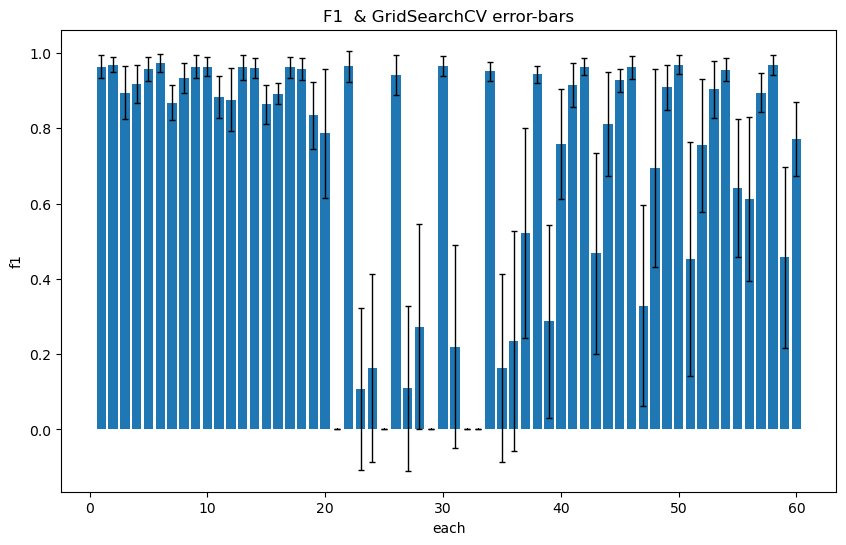

In [176]:
import matplotlib.pyplot as plt
def graph(means,stds,title,xlabel,ylabel):
    x = range(1,len(means)+1) 
    y = means
    fig = plt.figure(figsize=(10,6),dpi=100)
    ax1 = fig.add_subplot()
    bar_width = 0.4 
    ax1.bar(x, y) 
    ax1.errorbar(x, y, yerr=stds, capsize=2, elinewidth=1, fmt=' k,')  
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()
#means, stds
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
#show f1 score for each combination of hyperparameters
graph(means,stds,"F1  & GridSearchCV error-bars","each","f1")

In [ ]:
#### Bayesian Optimization

The following code uses BayesSearchCV to search the best parameters of MLP and visualize the results at the same time. We search for learning rate, activation function, optimizer, number of neurons and number of layers, and the best score and hyperparameters are shown as follows: 

0.9741820031610162   {'activation': 'relu', 'hidden_layer_sizes': (20, 15, 10), 'learning_rate_init': 0.001, 'solver': 'adam'}

In [99]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UserWarning)

In [139]:
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

#use BayesSearchCV to search the best parameters of MLP，
#Because it does not provide a hyperparameter search on tuple data types，
#we can only pass in the number of layers and the number of neurons from the outside to tune it

def MLP_BO(layers):
    X = np.array(X_data)
    Y = np.array(Y_label)
   
    #build MLP moldel
    MLP = MLPClassifier(layers,max_iter=100)
    
    # define the grid search parameters
    Bayes = BayesSearchCV(
        MLP,
        {
            'activation': Categorical(['identity', 'logistic', 'relu']),
            'solver': Categorical(['sgd', 'adam']),
            'learning_rate_init': Real(1e-4, 1e-3, prior='log-uniform'),
        },
        n_jobs=-1,
        cv=10,
        scoring='f1'
    )
    
    #Start Bayesian Optimization, using ten fold cross validation, using F1 score
    Bayes.fit(X, Y)
    return Bayes
            



In [140]:
#Generate a layser_set（combinations of one, two and three layers for hidden_layer_sizes）
layer_1=range(10,20,5)
layer_2=range(10,20,5)
layer_3=range(10,20,5)
layer_set = []
for i in layer_1:
    layer_set.append((i))
    for j in layer_2:
        layer_set.append((i,j))
        for k in layer_3:
            layer_set.append((i,j,k))

#run the MLP_BO function，pass in hidden_layer_sizes and collect the result            
BO_result = []
for layers in layer_set:
    BO_result.append(MLP_BO(layers))

/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

In [171]:
#pick the best one out of all the result we have collected
best_score = 0
for i in range(len(layer_set)):
    if BO_result[i].best_score_ > best_score:
        best_score = BO_result[i].best_score_
        best_layers = layer_set[i]
        best_params = BO_result[i].best_params_
        n = i
    print(BO_result[i].best_score_,"layers:",layer_set[i],BO_result[i].best_params_)
print("\n the best score and hyperparameter for MLP_BO: \n")
print(best_score,"layers:",best_layers,best_params)
    

0.9734890105168039 layers: 10 OrderedDict([('activation', 'identity'), ('learning_rate_init', 0.001), ('solver', 'adam')])
0.9759554871296222 layers: (10, 10) OrderedDict([('activation', 'relu'), ('learning_rate_init', 0.001), ('solver', 'adam')])
0.9735052534910731 layers: (10, 10, 10) OrderedDict([('activation', 'identity'), ('learning_rate_init', 0.0009508471649224479), ('solver', 'adam')])
0.9734866614446875 layers: (10, 10, 15) OrderedDict([('activation', 'identity'), ('learning_rate_init', 0.001), ('solver', 'adam')])
0.9760689301245172 layers: (10, 15) OrderedDict([('activation', 'identity'), ('learning_rate_init', 0.0006550201893941893), ('solver', 'adam')])
0.9760472851028721 layers: (10, 15, 10) OrderedDict([('activation', 'identity'), ('learning_rate_init', 0.0009938410161878476), ('solver', 'adam')])
0.9807146908678389 layers: (10, 15, 15) OrderedDict([('activation', 'identity'), ('learning_rate_init', 0.001), ('solver', 'adam')])
0.97392607298166 layers: 15 OrderedDict([('

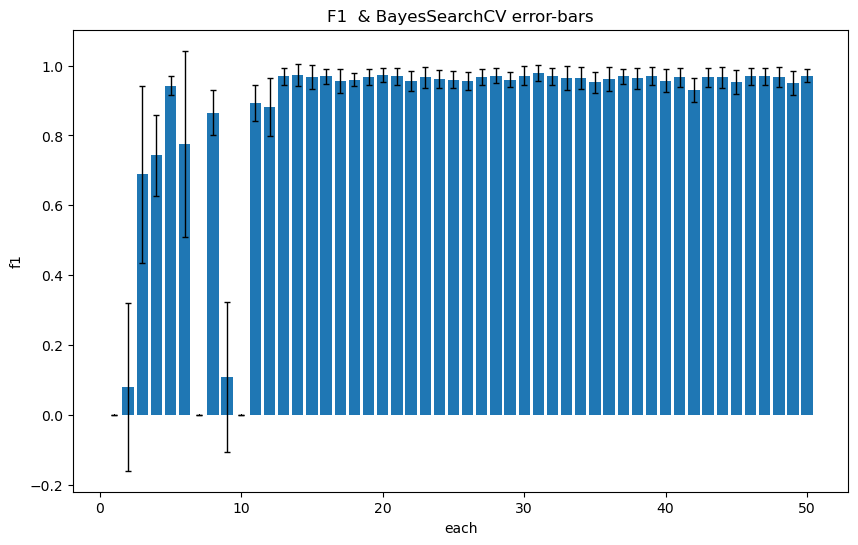

In [172]:
means = BO_result[i].cv_results_['mean_test_score']
stds = BO_result[i].cv_results_['std_test_score']
#show f1 score for each combination of hyperparameters
graph(means,stds,"F1  & BayesSearchCV error-bars","each","f1") 

In [16]:
#############

We investigate the first scenarios

MLP_Funnel best score and best hyperparameters:

0.9741455761733697 {'activation': 'relu', 'hidden_layer_sizes': (40, 30, 15), 'learning_rate_init': 0.001, 'solver': 'adam'}


In [116]:

def MLP_Funnel():
    X = np.array(X_data)
    Y = np.array(Y_label)

    MLP = MLPClassifier(max_iter=100, verbose=False)

    # define the hyperparameters parameters, for MLP_Funnel, we set hidden_layer_sizes as a "funnel" shape.
    hyperparameters = {
        'hidden_layer_sizes': [(60,30,15),(60,30,10),(60,15,15),(60,15,10),(40,30,15),(40,30,10),(40,15,15),(40,15,10)],
        'activation': ['identity', 'logistic', 'relu'],
        'solver': ['sgd', 'adam'],
        'learning_rate_init': [0.001,0.0001]
     }

    #Start grid search, using ten fold cross validation, using F1 as the criterion
    grid = GridSearchCV(MLP, hyperparameters, n_jobs=-1, cv=10, scoring='f1') 

    grid.fit(X, Y)
    
    return  grid 


In [118]:
Funnel_result = MLP_Funnel()

/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

In [119]:
print(Funnel_result.best_score_,Funnel_result.best_params_)

0.9741455761733697 {'activation': 'relu', 'hidden_layer_sizes': (40, 30, 15), 'learning_rate_init': 0.001, 'solver': 'adam'}


It can be seen that the MLP Funnel model parameters are as follows: the F1 is 0.9741455761733697
, the best hyperparameter is {'activation': 'relu', 'hidden_layer_sizes': (40, 30, 15), 'learning_rate_init': 0.001, 'solver': 'adam'}

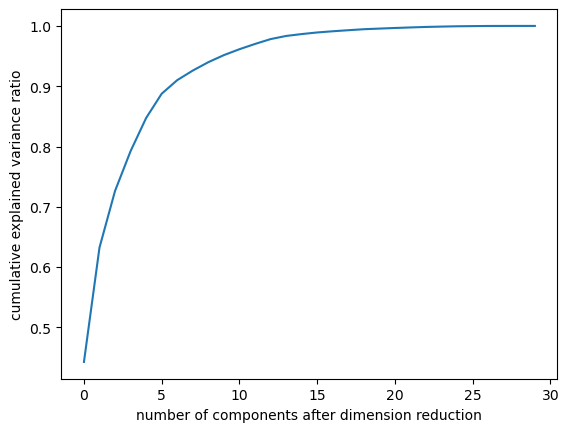

In [187]:
#Call the standard LAPACK resolver from scipy.linalg.svd 
import numpy as np
from sklearn.decomposition import PCA
pca_line = PCA(svd_solver="full").fit(X) 
plt.plot(np.cumsum(pca_line.explained_variance_ratio_))
plt.xlabel("number of components after dimension reduction")
plt.ylabel("cumulative explained variance ratio")
plt.show()

In [189]:
#SVD
from sklearn.decomposition import PCA

X = np.array(X_data)
Y = np.array(Y_label)

print(X.shape)
#PCA dimension reduction, here we will reduce the dimension
pca_f = PCA(n_components=0.9,svd_solver="full")
pca_f = pca_f.fit(X)
X_f = pca_f.transform(X)
pca_f.explained_variance_ratio_
print(X_f.shape)

(569, 30)
(569, 7)


Pre-process the data using low-rank SVD and use that preprocessed data as input to MLP_BO and MLP_grid.

Input preprocessed data to MLP_Grid, F1: 0.9594390955990504，
Input preprocessed data to MLP_BO，F1: 0.964425553648469，

In [190]:
def MLP_Grid():
    X = np.array(X_f)
    Y = np.array(Y_label)

    MLP = MLPClassifier(max_iter=100, verbose=False)

    # define the grid search parameters
    hyperparameters = {
        'hidden_layer_sizes': [(20,15,10)],
        'activation': ['identity'],
        'solver': ['adam'],
        'learning_rate_init': [0.001]
     }

    #Start grid search, using ten fold cross validation, using F1 as the criterion
    grid = GridSearchCV(MLP, hyperparameters, n_jobs=-1, cv=10, scoring='f1') 

    grid.fit(X, Y)
    
    return  grid 

In [191]:
grid_result2 = MLP_Grid()

/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

In [192]:
print(grid_result2.best_score_)

0.9594390955990504


In [193]:
def MLP_BO(layers):
    X = np.array(X_f)
    Y = np.array(Y_label)
   
    MLP = MLPClassifier(layers,learning_rate_init=0.001,max_iter=100)

    Bayes = BayesSearchCV(
        MLP,
        {
            'activation': Categorical(['identity']),
            'solver': Categorical(['adam']),
        },
        n_jobs=-1,
        cv=10,
        scoring='f1'
    )

    Bayes.fit(X, Y)
    return Bayes

In [194]:
result = MLP_BO((20, 15, 10))

/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/Use

In [196]:
print(result.best_score_)

0.964425553648469


In [ ]:
#########Evaluate our selection of MLP model with the best hyperparameters########

In [200]:
def MLP_Grid():
    X = np.array(X_data)
    Y = np.array(Y_label)

    MLP = MLPClassifier( verbose=False)

    # define the grid search parameters
    hyperparameters = {
        'hidden_layer_sizes': [(20,15,10)],
        'activation': ['identity'],
        'solver': ['adam'],
        'learning_rate_init': [0.001],
        'max_iter' : [50,100,150,200]
     }

    #Start grid search, using ten fold cross validation, using F1 as the criterion
    grid = GridSearchCV(MLP, hyperparameters, n_jobs=-1, cv=10, scoring='f1') 

    grid.fit(X, Y)
    
    return  grid 

In [201]:
grid_result1 = MLP_Grid()

/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/l

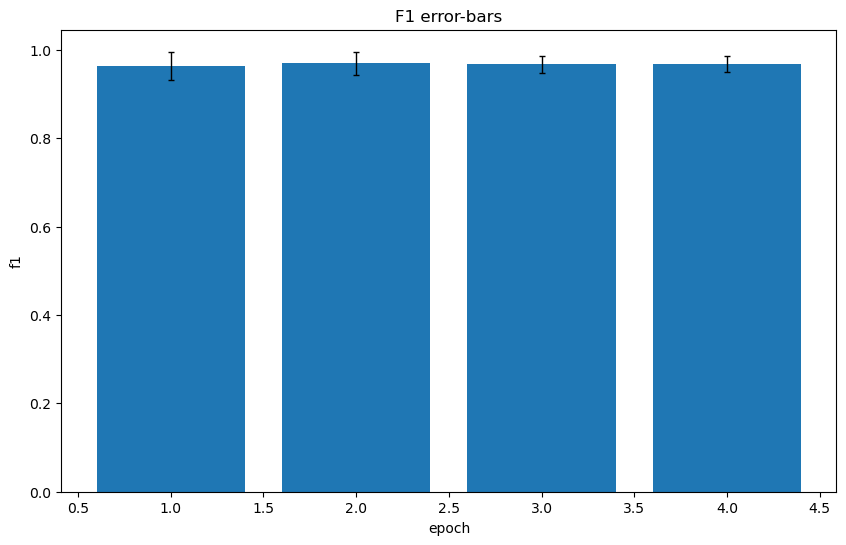

In [202]:
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
graph(means,stds,"F1 error-bars","epoch","f1")

In [204]:
def MLP_Grid():
    X = np.array(X_data)
    Y = np.array(Y_label)

    MLP = MLPClassifier( verbose=False)
    
    epochlist = []
    for i in range(1,200):
        epochlist.append(i)

    # define the grid search parameters
    hyperparameters = {
        'hidden_layer_sizes': [(20,15,10)],
        'activation': ['identity'],
        'solver': ['adam'],
        'learning_rate_init': [0.001],
        'max_iter' : epochlist
     }

    #Start grid search, using ten fold cross validation, using F1 as the criterion
    grid = GridSearchCV(MLP, hyperparameters, n_jobs=-1, cv=10, scoring='f1')  #scoring = 'accuracy' 'recall'

    grid.fit(X, Y)
    
    return  grid 

In [206]:
grid_result4 = MLP_Grid()

/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litianyang/opt/anaconda3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/litia

In [207]:
means_f1 = grid_result4.cv_results_['mean_test_score']

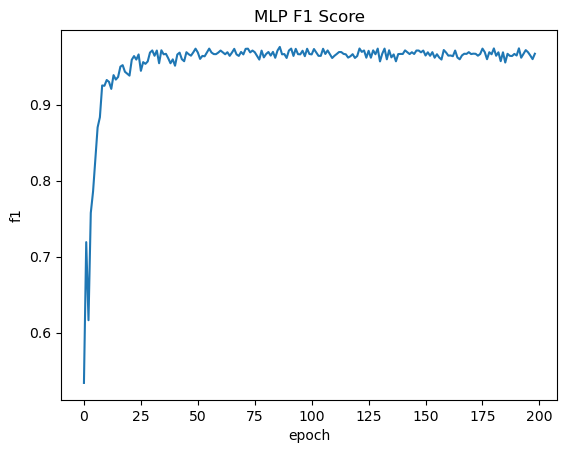

In [211]:
plt.figure()
ax2 = plt.axes()
plt.xlabel('epoch')
plt.ylabel('f1')
plt.title("MLP F1 Score")
plt.plot(means)

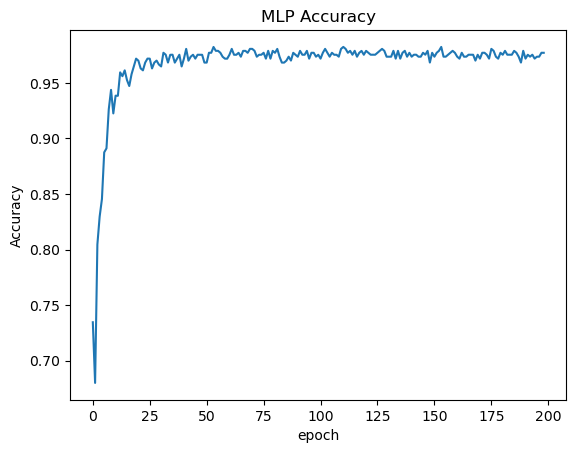

In [218]:
means = grid_result5.cv_results_['mean_test_score']
plt.figure()
ax2 = plt.axes()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title("MLP Accuracy")
plt.plot(means)

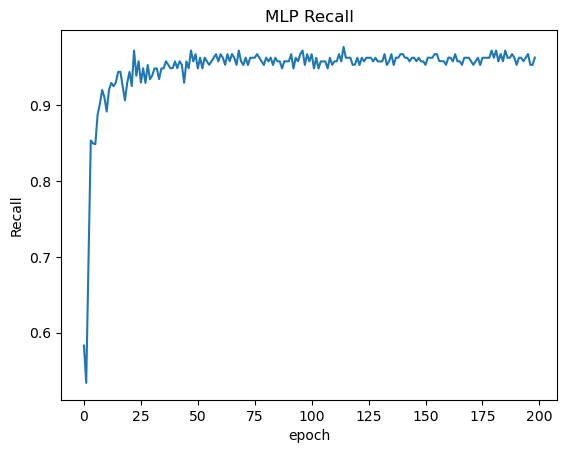

In [217]:
means_recall = grid_result6.cv_results_['mean_test_score']
plt.figure()
ax2 = plt.axes()
plt.xlabel('epoch')
plt.ylabel('Recall')
plt.title("MLP Recall")
plt.plot(means_recall)